# Знакомство с данными

In [1]:
#Необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
#Вспомогательные библиотеки
import re
# Отключил пердупреждения для чистоты вывода
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
main = pd.read_csv('data/poverty_percent_by_regions_1992_2020.csv')
main

,region,year,poverty_percent
0,Российская Федерация,1992,33.5
1,Российская Федерация,1993,31.3
2,Российская Федерация,1994,22.4
3,Российская Федерация,1995,24.8
4,Российская Федерация,1996,22.1
...,...,...,...
2334,Чукотский автономный округ,2017,8.5
2335,Чукотский автономный округ,2018,8.8
2336,Чукотский автономный округ,2019,8.5
2337,Чукотский автономный округ,2020,8.0


In [3]:
main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   region           2339 non-null   object 
 1   year             2339 non-null   int64  
 2   poverty_percent  2339 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 54.9+ KB


Данные не содержат пропусков, типы данных присвоены правильно

In [4]:
main.describe()

,year,poverty_percent
count,2339.000000,2339.000000
mean,2007.799487,20.236597
std,7.434428,13.357606
min,1992.000000,0.000000
25%,2002.000000,12.500000
50%,2008.000000,17.300000
75%,2014.000000,25.500000
max,2020.000000,98.400000


Данные за 1992-2020 год, процент бедности от 0 до 98.4%

In [5]:
# Так как данные по следующим областям представлены в агрегированном виде до 2012 года, отставлю их так и удалю аггрегированные после 2011
main['region']=main['region'].apply(lambda x: x.strip())
main = main[~main.index.isin(main[(main['region']=='Архангельская область')][main.year>2011].index)]
main = main[~main.index.isin(main[(main['region']=='Тюменская область')][main.year>2011].index)]
short_dict={'Архангельская область': 'Архангельская область (кроме Ненецкого автономного округа)',
            'Тюменская область': 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)'}
main.region = main.region.apply(lambda x: short_dict[x] if x in short_dict else x)

In [6]:
rf_main = main[main.region=='Российская Федерация'] # Сохраню отдельно данные по РФ перед удалением

In [7]:
def unified_regions(df):
    '''функция для отбора нужных регионов
    дополняется по мере знакомства с датасетами'''
    df = df.dropna(subset = 'region')
    df['region']=df['region'].apply(lambda x: x.strip())
    # Удалим аггрегационные данные (округа и две области, содержащие регионы)
    df=df.loc[~(df['region'].str.contains('федеральный'))&
                    ~(df['region'] == 'Архангельская область')&
                    ~(df['region'] == 'Тюменская область')&
                    ~(df['region'] == 'Российская Федерация'),:]

    # Сократим названия
    def find_similar(s):
        mydict={'оскв':'Город Москва',
            'етербург': 'Город Санкт-Петербург',
            'евастополь': 'Город Севастополь',
            'город Севастополь': 'Город Севастополь',
            'Архангельская область ': 'Архангельская область [кроме..]',
            'Тюменская область ': 'Тюменская область [кроме..]',
            'Чувашская Республика': 'Чувашская Республика - Чувашия',
            'Ханты-Мансийский авт':'Ханты-Мансийский автономный округ - Югра',
            'Кемеровская область':'Кемеровская область - Кузбасс',
            ' Саха':'Республика Саха'}
        for key in mydict:
            if key in s:
                return (mydict[key])
        return (s)
    df.region = df.region.apply(find_similar)
    df.region  = df.region.apply(lambda x: re.sub(r' \([^)]*\)|\[[^\]]*\]|\{[^}]*\}', '', x))
    df.region  = df.region.str.replace('авт. округ', 'автономный округ')
    df.region  = df.region.str.replace('авт. область', 'автономная область')
    df.region  = df.region.str.replace('B', 'В')
    return df

In [8]:
main = unified_regions(main)

In [9]:
len(main.region.unique())

85

In [10]:
main['poverty_percent'].value_counts(dropna=False)

poverty_percent
0.0     36
14.2    22
13.6    21
14.9    21
13.0    19
        ..
68.9     1
55.2     1
46.2     1
44.3     1
50.1     1
Name: count, Length: 474, dtype: int64

In [11]:
# Пробовал разные подходы к замене нулей, но в результате вижу самым логичным от них избавиться. Но сделаю это после построения карты, а то некрасиво получается)
# main = main.replace(0,np.nan).dropna()

# EDA

## Интерактивная карта

Добавим регионы для отрисовки

In [12]:
# Код на географические координаты брал в интернете (может можно оптимизировать, но не хочу менять то, что работает)
from urllib.request import urlopen
import json
import requests
with urlopen('https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/russia.geojson') as response:
    counties = json.load(response)


regions_republic_1 = ['Бурятия', 'Тыва', 'Адыгея', 'Татарстан', 'Марий Эл', 'Алтай',
                      'Дагестан', 'Ингушетия', 'Башкортостан']
regions_republic_2 = ['Удмуртская республика', 'Кабардино-Балкарская республика',
                      'Карачаево-Черкесская республика', 'Чеченская республика']
for k in range(len(counties['features'])):
    counties['features'][k]['id'] = k
    if counties['features'][k]['properties']['name'] in regions_republic_1:
        counties['features'][k]['properties']['name'] = 'Республика ' + counties['features'][k]['properties']['name']
    elif counties['features'][k]['properties']['name'] in regions_republic_2:
        counties['features'][k]['properties']['name'] = counties['features'][k]['properties']['name'].title()
    elif counties['features'][k]['properties']['name'] == 'Архангельская область':
        counties['features'][k]['properties']['name'] = 'Архангельская область [кроме..]'        
    elif counties['features'][k]['properties']['name'] == 'Тюменская область':
        counties['features'][k]['properties']['name'] = 'Тюменская область [кроме..]'
    elif counties['features'][k]['properties']['name'] == 'Северная Осетия - Алания':
        counties['features'][k]['properties']['name'] = 'Республика Северная Осетия-Алания'
    elif counties['features'][k]['properties']['name'] == 'Чувашия':
        counties['features'][k]['properties']['name'] = 'Чувашская Республика - Чувашия'
    elif counties['features'][k]['properties']['name'] == 'Республика Саха (Якутия)':
        counties['features'][k]['properties']['name'] = 'Республика Саха'    
            
region_id_list = []
regions_list = []
for k in range(len(counties['features'])):
    region_id_list.append(counties['features'][k]['id'])
    regions_list.append(counties['features'][k]['properties']['name'])
df_regions = pd.DataFrame()
df_regions['region_id'] = region_id_list
df_regions['region'] = regions_list
short_dict={'Москва':'Город Москва',
            'Санкт-Петербург': 'Город Санкт-Петербург',
            'Город Санкт-Петербург город федерального значения': 'Город Санкт-Петербург',
            'Город федерального значения Севастополь': 'Город Севастополь',
            'Архангельская область (кроме Ненецкого автономного округа)': 'Архангельская область [кроме..]',
            'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)': 'Тюменская область [кроме..]',
            'Чувашская Республика': 'Чувашская Республика - Чувашия',
            'Ханты-Мансийский автономный округ':'Ханты-Мансийский автономный округ - Югра',
            'Кемеровская область':'Кемеровская область - Кузбасс'}
df_regions.region = df_regions.region.apply(lambda x: short_dict[x] if x in short_dict else x)

In [13]:
main = main.merge(df_regions, how='left', on=['region'])

In [14]:
len(main.region.unique())

85

In [15]:
# Красивое, но лагает, раскомментить при необходимости.

#строим график
"""fig = px.choropleth_mapbox(geojson=counties,
    data_frame=main_map,
    locations="region_id",
    color="poverty_percent",
    animation_frame="year",
    hover_data = {'region_id':False,'year':False, 'poverty_percent':True,'region':True},
    color_continuous_scale = "Temps",
    width=1000,
    height=600,
    center = {"lat": 66, "lon": 110}

)

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0),mapbox_style="carto-positron",mapbox_zoom=1.5)
fig.show()"""

# Сохраним результат
"""html = fig.to_html()
with open("figures/map.html", "w", encoding="utf-8") as f:
    f.write(html)"""

'html = fig.to_html()\nwith open("figures/map.html", "w", encoding="utf-8") as f:\n    f.write(html)'

В некоторых регионах стабильно малый процент(Тюменская область и округа), где-то всегда большой (Республика Тыва). Заметен резкий спад процента по России в 2012. Но посмотрим подробнее

In [16]:
main = main.drop('region_id', axis =1)

## Процент бедности

In [17]:
# Удаляю нулевые проценты бедности
main = main.replace(0,np.nan).dropna()

In [18]:
len(main.region.unique())

85

In [19]:
px.line(pd.concat([rf_main,main]),
        x='year',
        y='poverty_percent',
        color='region',
        width=1200,
        height=600)

Сложно, конечно, анализировать все сразу. Посмотрим топы.

In [20]:
# Отрисуем регоны, которые лидировали по проценту бедности в какие-либо года
max_poverty_percent=pd.DataFrame(columns=main.columns)
for year in main.year.unique():
    df = main[main['year']==year]
    max_poverty_percent = pd.concat([max_poverty_percent, df.sort_values('poverty_percent',ascending=False).head(1)], ignore_index = True)

px.line(main[main.region.isin(max_poverty_percent.region.unique())],
        x='year',
        y='poverty_percent',
        color='region',
        width=1200,
        height=600)

Видим, что всего три региона лидировали по доле бедности. Интересно, а если посмотреть топ-3?

In [21]:
max_poverty_percent=pd.DataFrame(columns=main.columns)
for year in main.year.unique():
    df = main[main['year']==year]
    max_poverty_percent = pd.concat([max_poverty_percent, df.sort_values('poverty_percent',ascending=False).head(3)], ignore_index = True)

px.line(main[main.region.isin(max_poverty_percent.region.unique())],
        x='year',
        y='poverty_percent',
        color='region',
        width=1200,
        height=600)

Добавилось достаточно много областей, то есть в лидерах не всегда одни и те же. Заметно, что все их графики начинались выше среднего по России. Может это важно?

In [22]:
vis = main[(main['year']==1995)&(main['poverty_percent']>=24.8)]

px.line(main[main.region.isin(vis.region.unique())],
        x='year',
        y='poverty_percent',
        color='region',
        width=1200,
        height=600)

По графику видно, что часть опустилась ниже среднего

In [23]:
print(f'Регионы беднее среднего по России в 1995:', vis.shape[0])
vis2 = main[(main.region.isin(vis.region.unique()))&(main['year']==2020)&(main['poverty_percent']>=12.1)]
print(f'Из них беднее среднего в 2020:', vis2.shape[0])
vis3 = main[(~main.region.isin(vis.region.unique()))&(main['year']==2020)&(main['poverty_percent']>=12.1)]
print(f'Других регионов беднее среднего в России в 2020:', vis3.shape[0])
print(f'Всего регионов беднее среднего в России в 2020:', vis2.shape[0]+vis3.shape[0])

Регионы беднее среднего по России в 1995: 49
Из них беднее среднего в 2020: 38
Других регионов беднее среднего в России в 2020: 18
Всего регионов беднее среднего в России в 2020: 56


Бедность в большинстве этих регионов так и осталась выше среднего, но судя по прибавлению других регионов к 2020, это не единственный определяющий фактор.
Думаю стоит перейти от процентов к абсолютным числам населения

## Количество бедностей

In [24]:
# population.xlsx модифицировался вручную для удобства
pop = pd.read_excel('data/population_edit.xlsx')
pop.head()

,region,1999,2000,2001,2002,2003,2004,2005,2006,2007,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Российская Федерация,147539426.0,146890128.0,146303611.0,145649334.0,144963650.0,144333586.0,143801046.0,143236582.0,142862692.0,...,143347059.0,143666931.0,146267288.0,146544710.0,146804372.0,146880432.0,146780720.0,146748590.0,146171015.0,145557576.0
1,Центральный федеральный округ,38311159.0,38227656.0,38175094.0,38068452.0,37946810.0,37965073.0,38044068.0,38109006.0,38183357.0,...,38678913.0,38819874.0,38951479.0,39104319.0,39209582.0,39311413.0,39378059.0,39433556.0,39250960.0,39104400.0
2,Белгородская область,1494868.0,1501699.0,1506976.0,1508137.0,1511899.0,1513860.0,1511662.0,1511715.0,1514153.0,...,1540985.0,1544108.0,1547936.0,1550137.0,1552865.0,1549876.0,1547418.0,1549151.0,1541259.0,1531917.0
3,Брянская область,1437471.0,1423178.0,1407965.0,1391430.0,1375004.0,1360249.0,1344132.0,1327652.0,1312748.0,...,1253666.0,1242599.0,1232940.0,1225741.0,1220530.0,1210982.0,1200187.0,1192491.0,1182682.0,1168771.0
4,Владимирская область,1592184.0,1575507.0,1558052.0,1539179.0,1520057.0,1509571.0,1497598.0,1486453.0,1475861.0,...,1421742.0,1413321.0,1405613.0,1397168.0,1389599.0,1378337.0,1365805.0,1358416.0,1342099.0,1323659.0


In [25]:
# Сократим названия
pop = unified_regions(pop.dropna(axis=0,subset='region'))

In [26]:
# конвертируем таблицу wide-to-long, уберем значения позже 2020
pop_df = pd.melt(pop,id_vars='region',var_name='year',value_name='population')
pop_df

,region,year,population
0,Белгородская область,1999,1494868.0
1,Брянская область,1999,1437471.0
2,Владимирская область,1999,1592184.0
3,Воронежская область,1999,2458558.0
4,Ивановская область,1999,1210603.0
...,...,...,...
2179,Амурская область,2022,772525.0
2180,Магаданская область,2022,137767.0
2181,Сахалинская область,2022,484177.0
2182,Еврейская автономная область,2022,153831.0


In [27]:
# Проверим, что все регионы основного датасета находятся в дополнительном
set(main.region.unique())-(set(pop_df.region.unique()))

set()

In [28]:
len(main.region.unique())

85

In [29]:
main = main.merge(pop_df, how='left', on=['region','year'])

In [30]:
#Заменим популяцию в старых годах первым доступным значением
main.population = main.population.bfill()

In [31]:
pd.set_option('display.float_format', lambda x: '%.2f' % x) # делает читаемым числа
# добавим абсолютные значения бедного населения
main['poverty_population'] = main.poverty_percent*main.population/100

In [32]:
px.line(main,
        x='year',
        y='poverty_population',
        color='region',
        width=1200,
        height=600)

Сложно, конечно, анализировать все сразу. Посмотрим топы.

In [33]:
max_main=pd.DataFrame(columns=main.columns)
for year in main.year.unique():
    df = main[main['year']==year]
    max_main = pd.concat([max_main, df.sort_values('poverty_population',ascending=False).head(1)], ignore_index = True)
max_main
px.line(main[main.region.isin(max_main.region.unique())],
        x='year',
        y='poverty_population',
        color='region',
        width=1200,
        height=600)

Ну тут ожидаемо Москва и МО берут числом

Отберём топ-регионов с наибольшим числом населения за чертой бедности

In [34]:
max_main=pd.DataFrame(columns=main.columns)
for year in main.year.unique():
    df = main[main['year']==year]
    max_main = pd.concat([max_main, df.sort_values('poverty_population',ascending=False).head(5)], ignore_index = True)

px.line(main[main.region.isin(max_main.region.unique())],
        x='year',
        y='poverty_population',
        color='region',
        width=1200,
        height=600)

In [35]:
vis = main[main['year']==2020]
px.scatter(vis, x = 'poverty_population', y='poverty_percent', color='region')

Ну вот, до применения моделей, можно уже сказать, каким регионам необходимо больше тратить на поддержку малообеспеченного населения

## Показатели социальной незащищенности

### Возраст

In [36]:
df_socdem = pd.DataFrame()
for year in range(2017,2021):
    socdem = pd.read_excel(f'data/poverty_socdem_{year}.xls',skiprows=[0,1])
    socdem = socdem.drop(['Все население','Население трудоспособного возраста'], axis=1) # удалил колонки не несущие новой информации
    socdem = socdem.rename({'Unnamed: 0': 'region', 'Дети в возрасте до 16 лет':'kids', "Население старше трудоспособного возраста": 'senior'},axis =1)
    socdem['year'] = year
    socdem = unified_regions(socdem)
    # Сократим названия
    df_socdem = pd.concat([df_socdem,socdem])
# Удалю строчки, в которых нули по всем соотношениям
df_socdem = df_socdem[(df_socdem.kids+df_socdem.senior)!=0]
df_socdem = df_socdem.sort_values(['region','year'])
# Тут чаще нет данных в поздних годах, так что применю ffill()
df_socdem = df_socdem.ffill()

In [37]:
# Проверим, что все регионы основного датасета находятся в дополнительном
set(main.region.unique())-(set(pop_df.region.unique()))


set()

In [38]:
main = main.merge(df_socdem, how='left', on=['region','year'])

In [39]:
px.imshow(main.corr(numeric_only=True),color_continuous_scale='Bluered')

Относительные и абсолютные количества бедностей не зависят от возрастного состава субъектов

### Инвалидности

In [40]:
disabled = pd.read_csv('data/disabled_total_by_age_2017_2022.csv')
disabled

,region,total,18_30,31_40,41_50,51_60,60_,date
0,Российская Федерация,11640873.00,550895.00,766054.00,1030652.00,2135436.00,7157836.00,2017-01-01
1,Центральный федеральный округ,3420310.00,118579.00,172662.00,257484.00,598102.00,2273483.00,2017-01-01
2,Белгородская область,223030.00,6318.00,10383.00,16596.00,37444.00,152289.00,2017-01-01
3,Брянская область,110418.00,4215.00,6568.00,10230.00,21481.00,67924.00,2017-01-01
4,Владимирская область,133352.00,4454.00,6811.00,9606.00,23322.00,89159.00,2017-01-01
...,...,...,...,...,...,...,...,...
6075,Еврейская автономная область,11669.00,629.00,1167.00,1447.00,1624.00,6802.00,2022-04-01
6076,Чукотский автономный округ,1671.00,177.00,220.00,301.00,366.00,607.00,2022-04-01
6077,Республика Саха (Якутия),51362.00,4186.00,5536.00,6957.00,10118.00,24565.00,2022-04-01
6078,Приморский край,100734.00,4885.00,9090.00,12536.00,15527.00,58696.00,2022-04-01


In [41]:
disabled['region']=disabled['region'].apply(lambda x: x.strip())
#оставим от даты только год
disabled = disabled[disabled['date'].str.contains('01-01')] 
disabled['year'] = disabled['date'].str[:4].astype(int)
# сомневаюсь, что число инвалидностей по возрастам для нас существенно
disabled.drop(disabled.columns[2:8],axis=1,inplace=True)
disabled = disabled[disabled['year']<2021]

In [42]:
# Вычисления для регионов матрешек
disabled.loc[disabled['region'] == 'Архангельская область','total'] = (disabled.loc[disabled['region'] == 'Архангельская область','total'].values
                                                                        - disabled.loc[disabled['region'] == 'Ненецкий автономный округ','total'].values)
disabled.region  = disabled.region.str.replace('Архангельская область', 'Архангельская область [кроме..]')
disabled.loc[disabled['region'] == 'Тюменская область','total'] = (disabled.loc[disabled['region'] == 'Тюменская область','total'].values
                                                                        - disabled.loc[disabled['region'] == 'Ханты-Мансийский автономный округ','total'].values
                                                                        - disabled.loc[disabled['region'] == 'Ямало-Ненецкий автономный округ','total'].values)
disabled.region  = disabled.region.str.replace('Тюменская область', 'Тюменская область [кроме..]')

disabled.rename({'total':'disabled'},axis=1,inplace=True)

In [43]:
disabled = unified_regions(disabled)

In [44]:
# Проверим, что все регионы основного датасета находятся в дополнительном
set(main.region.unique())-(set(disabled.region.unique()))

set()

In [45]:
main = main.merge(disabled, how='left', on=['region','year'])

In [46]:
# Переведем disabled в долю от населения
main['disabled_percent']=main['disabled']/main['population']*100

In [47]:
px.imshow(main.corr(numeric_only=True),color_continuous_scale='Bluered')

Можно подумать, что процент бедных зависит от количества инвалидностей, но это скорее проявление мультиколлинеарности и малого числа данных. Прямая зависимость таргета от процента инвалидностей мала. То же наблюдается для процентов детей и пенсионеров.

In [48]:
px.imshow(main[main.year>2016].corr(numeric_only=True),color_continuous_scale='Bluered')

Да, на промежутке 4 лет процент бедности так же коррелирует с общим населением региона, как и с числом инвалидностей

### Жилищные условия

In [49]:
housing_space = pd.read_excel('data/housing_2020.xlsx')
#housing_space

In [50]:
housing_space = housing_space.rename({housing_space.columns[0]:'region'},axis=1)
housing_space['year'] = 2020

In [51]:
housing_space = unified_regions(housing_space)
sorted(set(main.region.unique())-(set(housing_space.region.unique())))

[]

In [52]:
# Не хочу добавлять данные в основной датасет, так тут всего один год. Буду рассматривать отдельно
test = main.iloc[:,:3].merge(housing_space, how='left', on=['region','year'])

In [53]:
# Посмотрю на заметные корреляции, потом переименую нужные колонки
test.corr(numeric_only=True)['poverty_percent'].sort_values(ascending=False)

poverty_percent                                                                                  1.00
Число жилых комнат в расчете на одно домохозяйство                                               0.51
Размер жилой площади в расчете на члена домохозяйства                                            0.25
в том числе домохозяйства, указавшие, что при проживании испытывают большую стесненность         0.15
Размер общей площади в расчете на члена домохозяйства                                            0.10
в том числе домохозяйства, указавшие, что при проживании испытывают определенную стесненность   -0.01
в том числе домохозяйства, указавшие, что при проживании не испытывают стесненности             -0.04
затруднились ответить                                                                           -0.09
Число домохозяйств, проживающих во всех типах жилых помещений                                     NaN
Name: poverty_percent, dtype: float64

In [54]:
housing_space = housing_space.rename({housing_space.columns[7]:'living_space',
                          housing_space.columns[8]:'living_rooms'}, axis=1)
housing_space = housing_space.drop(housing_space.columns[1:7],axis=1)

In [55]:
housing_cond= pd.read_excel('data/housing_2020.xlsx',sheet_name=1)
#housing_cond

In [56]:
housing_cond = housing_cond.rename({housing_cond.columns[0]:'region'},axis=1)
housing_cond['year'] = 2020
housing_cond = housing_cond.replace('...',np.nan)
housing_cond = housing_cond.replace('...*',np.nan)


In [57]:
housing_cond = housing_cond.fillna(housing_cond.iloc[0])

In [58]:
housing_cond = unified_regions(housing_cond)
sorted(set(main.region.unique())-(set(housing_cond.region.unique())))
test = main.iloc[:,:3].merge(housing_cond, how='left', on=['region','year'])

In [59]:
test.corr(numeric_only=True)['poverty_percent'].sort_values(ascending=False)

poverty_percent                                                                                                                                                  1.00
из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются улучшить  свои  жилищные условия  другим способом                                 0.42
из них домохозяйства, собирающиеся улучшить свои жилищные условия                                                                                                0.41
из них указавшие: на плохое состояние или очень плохое состояние жилого помещения и на стесненность проживания                                                   0.33
из них указавшие: на плохое или очень плохое состояние жилого помещения                                                                                          0.28
из них указавшие: на стесненность проживания                                                                                                                     0.25
из ч

In [60]:
housing_cond = housing_cond.rename({housing_cond.columns[2]:'improving_living_conditions',
                                      housing_cond.columns[-4]:'improving_living_conditions(other)', # Плохо понимаю смысл этого фактора, но такая хорошая корреляция!
                                      housing_cond.columns[5]:'cramped_and_bad_conditions',
                                      housing_cond.columns[7]:'counting_on_housing_from_gov',
                                      housing_cond.columns[9]:'bying_housing',
                                    housing_cond.columns[-2]:'not_improving_living_conditions'}, axis=1)
housing_cond = housing_cond.iloc[:,[0,2,5,7,9,-4,-2,-1]]

In [61]:
main = main.merge(housing_space, how='left', on=['region','year'])
main = main.merge(housing_cond, how='left', on=['region','year'])

In [62]:
px.imshow(main.corr(numeric_only=True)[['poverty_percent','poverty_population']],color_continuous_scale='Bluered')

Таким образом, в более бедных регионах живут на меньших площадях, в худших условиях и с меньшим числом жилых комнат. Больше стремятся улучшить жилижные условия, в том числе с помощью поддержки государства. В менее бедных меньше стремятся улучшить жилищные условия, и при этом чаще покупают жилье.
Уберу факторы, относящиеся к улучшениям условий, так как это скорее следствие уровня бедности, чем наоборот

In [63]:
main = main.drop(['improving_living_conditions','bying_housing','improving_living_conditions(other)','not_improving_living_conditions'], axis=1 )

# Кластеризация регионов России по нуждаемости в помощи малообеспеченным/неблагополучным слоям населения

In [64]:
# Пересмотрим корреляции в датасете, уберем слишком скореллированные факторы и неважные для отбора факторы
px.imshow(main.corr(numeric_only=True)[abs(main.corr(numeric_only=True))>0.5],color_continuous_scale='Bluered')

In [65]:
main = main.drop(['population','disabled','living_space','kids'], axis=1 )

## Размышления до кластеризации

Хотелось бы, чтобы оказались выделены кластеры
1) с наибольшим процентом бедных
2) наибольшим количеством бедных
3) наибольшим числом социально-незащищенных

Ну и кластеры групп в безопасности и промежуточных

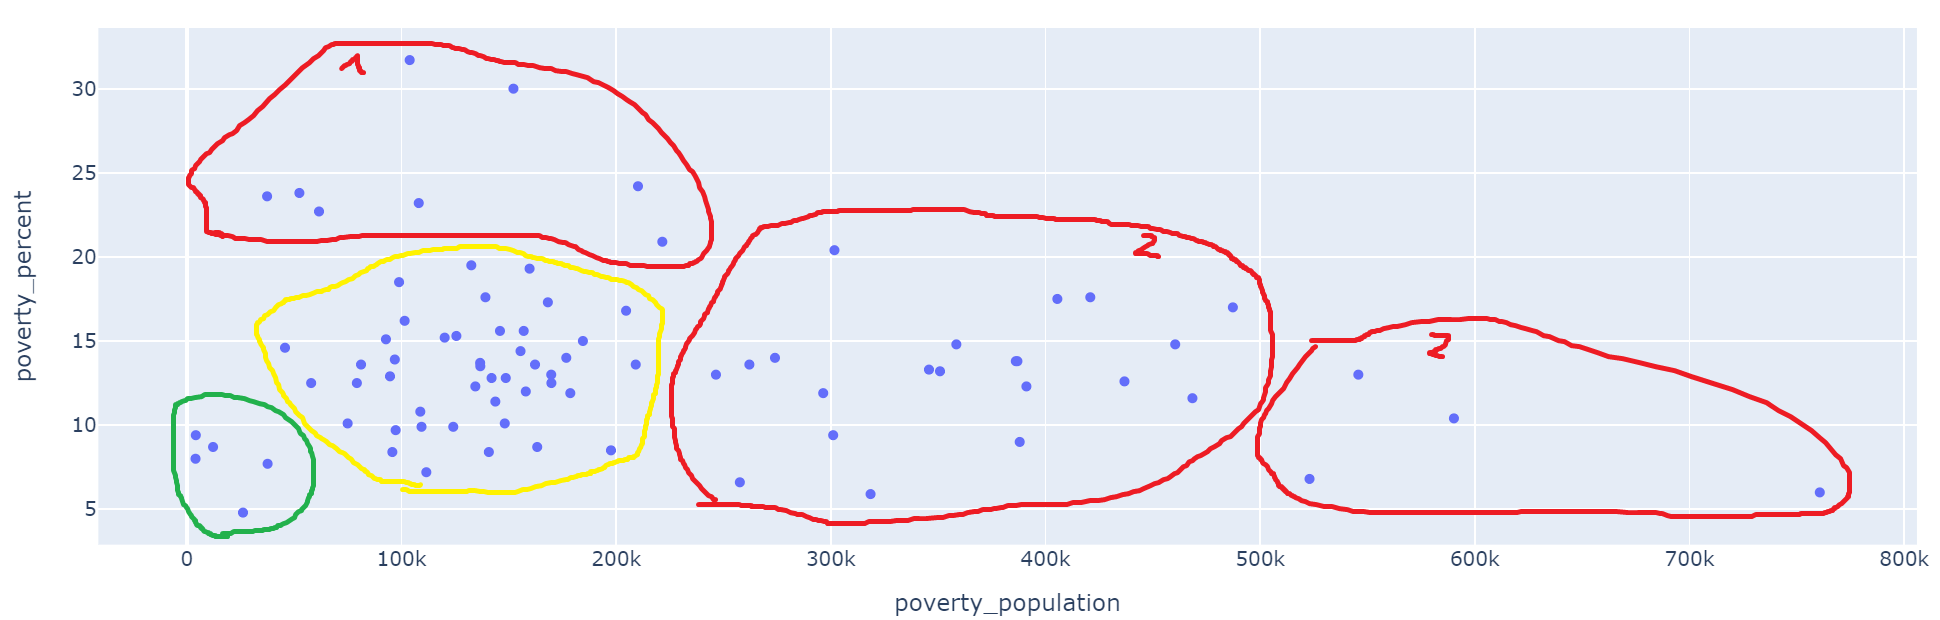

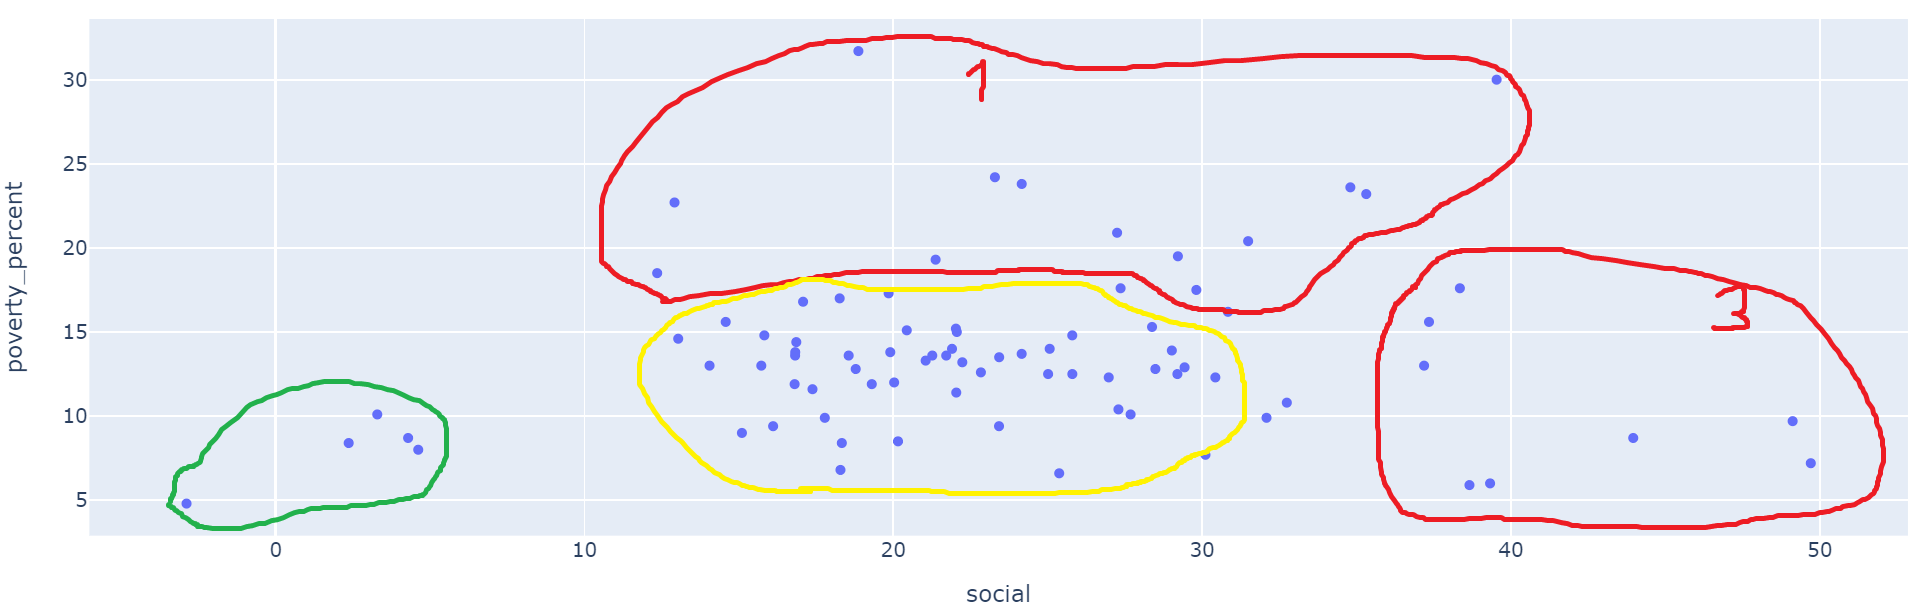

Про feature social обьясню позже

In [66]:
# Берем данные за 2020, чтобы делать выводы на 2021
test = main[main.year==2020].copy()

Я пробовал запускать кластеризацию по разроненным данным малообеспеченных/социально-незащищенных, но такой результат сложно интерперетировать.
Приведу ее в качестве baseline решения

## baseline

In [67]:
cluster_df=test.reset_index(drop=True)
# Отложим метки регионов
save_region_data = cluster_df.loc[:,['region']].reset_index(drop=True)
cluster_df.drop(['region'],axis=1,inplace=True)

In [68]:
cluster_df

,year,poverty_percent,poverty_population,senior,disabled_percent,living_rooms,cramped_and_bad_conditions,counting_on_housing_from_gov
0,2020,7.20,111538.87,12.90,12.91,2.60,0.40,1.60
1,2020,13.60,162178.78,3.70,8.91,3.20,0.00,3.80
2,2020,12.50,169802.00,4.80,9.07,2.20,0.00,1.70
3,2020,8.50,197557.42,2.30,9.33,2.60,0.10,3.70
4,2020,13.70,136607.49,5.00,7.78,2.40,0.90,1.30
...,...,...,...,...,...,...,...,...
80,2020,15.20,120086.69,4.70,8.19,2.30,0.30,5.50
81,2020,8.70,12192.96,0.00,3.57,1.90,0.00,3.80
82,2020,7.70,37595.79,12.10,4.43,2.10,0.00,3.80
83,2020,23.60,37359.98,10.80,7.98,2.20,0.50,3.80


In [69]:
# подготовим данные к кластеризации
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
cluster_df_scaled = pd.DataFrame(ss.fit_transform(cluster_df),columns = cluster_df.columns)
from sklearn.decomposition import PCA
#определяем метод главных компонент с двумя компонентами
pca = PCA(n_components=0.9)
#обучаем алгоритм на наших данных
X_pca = pca.fit_transform(cluster_df_scaled)

In [70]:
# Определим число кластеров
from sklearn import metrics
from sklearn.cluster import KMeans
#проходимся циклом по всем нужным нам значениям количества кластеров
ans = {'sil': (0,0), 'CH': (0,0), 'DB':(0,100)}
for i in range(2,11):
	# обучаем модель k-means с текущим количеством кластеров
    km = KMeans(n_clusters = i, random_state = 1 ).fit(X_pca)
	#предсказываем метки
    y_pred = km.labels_
	#выводим результат для коэффициента силуэта
    new_sil = metrics.silhouette_score(X_pca,  y_pred)
    new_CH = metrics.calinski_harabasz_score(X_pca,y_pred)
    new_DB = metrics.davies_bouldin_score(X_pca, y_pred)
    print (i,new_sil,new_CH,new_DB)
    if new_sil>ans['sil'][1]:
        ans['sil'] = (i,new_sil)
    if new_CH>ans['CH'][1]:
        ans['CH'] = (i,new_CH)
    if new_DB<ans['DB'][1]:
        ans['DB'] = (i,new_DB)
print (ans)

2 0.2581978585857954 15.88295051384682 1.695682629427202
3 0.23806796526101626 17.501401061810487 1.534056609463134
4 0.1708217369612435 17.26233872176167 1.514791325605121
5 0.18893227215361547 17.229714691291452 1.407059320917494
6 0.20838855962880007 19.157825055837773 1.237039547817381
7 0.2144712343858518 18.86143003332352 1.181432689491487
8 0.2082604533605255 18.69195751901959 1.1053169869031967
9 0.22692634916608775 18.595424476593074 1.0631128899456281
10 0.18520278425342881 17.87087947682311 1.0474983735573964
{'sil': (2, 0.2581978585857954), 'CH': (6, 19.157825055837773), 'DB': (10, 1.0474983735573964)}


In [71]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7, random_state=1)
kmeans.fit(X_pca)
cluster_res = cluster_df.copy()
cluster_res['cluster'] = kmeans.labels_
cluster_res = pd.concat([cluster_res.reset_index(drop=True),save_region_data],axis=1)

In [72]:
px.scatter(cluster_res, x = 'poverty_population', y='poverty_percent', color='cluster',
           hover_data={'region':True})

Регионы как-то делятся на кластеры. Есть кластеры с большим процентом бедности и большим числом бедностей. Но как выделяются остальные кластеры разобрать сложно.

## Введение параметра социальной незащищенности social


Соберем собственную формулу "нуждаемости региона в помощи"

In [133]:
test = main[main.year==2020].copy()
# Собираем фактор социально-незащищенных: неработающих и с плохими условиями жилья. Формула подбиралась "на глаз", так чтобы лучше разделить регионы
test['social']=test['senior']*2+test.disabled_percent*2+(-test.living_rooms+test.cramped_and_bad_conditions-test.counting_on_housing_from_gov)/2
test = test.drop(['senior','disabled_percent','living_rooms','cramped_and_bad_conditions','counting_on_housing_from_gov'],axis=1)


In [134]:
cluster_df=test.reset_index(drop=True)
# Отложим метки регионов
save_region_data = cluster_df.loc[:,['region']].reset_index(drop=True)
cluster_df.drop(['region'],axis=1,inplace=True)

# подготовим данные к кластеризации
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
cluster_df_scaled = pd.DataFrame(ss.fit_transform(cluster_df),columns = cluster_df.columns)
from sklearn.decomposition import PCA
#определяем метод главных компонент с двумя компонентами
pca = PCA(n_components=0.9)
#обучаем алгоритм на наших данных
X_pca = pca.fit_transform(cluster_df_scaled)

# Определим число кластеров
from sklearn import metrics
from sklearn.cluster import KMeans
#проходимся циклом по всем нужным нам значениям количества кластеров
ans = {'sil': (0,0), 'CH': (0,0), 'DB':(0,100)}
for i in range(2,11):
	# обучаем модель k-means с текущим количеством кластеров
    km = KMeans(n_clusters = i, random_state = 1 ).fit(X_pca)
	#предсказываем метки
    y_pred = km.labels_
	#выводим результат для коэффициента силуэта
    new_sil = metrics.silhouette_score(X_pca,  y_pred)
    new_CH = metrics.calinski_harabasz_score(X_pca,y_pred)
    new_DB = metrics.davies_bouldin_score(X_pca, y_pred)
    print (i,new_sil,new_CH,new_DB)
    if new_sil>ans['sil'][1]:
        ans['sil'] = (i,new_sil)
    if new_CH>ans['CH'][1]:
        ans['CH'] = (i,new_CH)
    if new_DB<ans['DB'][1]:
        ans['DB'] = (i,new_DB)
print (ans)

2 0.2864087181488763 28.014062276467325 1.2239455833470028
3 0.31936651891394163 33.03401740863899 1.0848253594235022


4 0.3187658749764576 39.804321964685535 0.9765840076527974
5 0.3405364065975983 41.34072192569183 0.876737103115488
6 0.3108976005609313 39.57914146263274 0.8992317228592238
7 0.31448730170254974 40.56606532852598 0.8986472803550508
8 0.30375857991010774 39.13320658579019 0.9269985246446437
9 0.2708649431525536 37.7969887036597 0.90887912290069
10 0.264398283838606 36.59970214389194 1.0109547686677944
{'sil': (5, 0.3405364065975983), 'CH': (5, 41.34072192569183), 'DB': (5, 0.876737103115488)}


Круто, что по метрикам выделется именно 5 кластеров, как хотелось

In [135]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_pca)
cluster_res = cluster_df.copy()
cluster_res['cluster'] = kmeans.labels_
cluster_res = pd.concat([cluster_res.reset_index(drop=True),save_region_data],axis=1)

In [126]:
px.scatter(cluster_res, x = 'poverty_population', y='poverty_percent', color='cluster',
           hover_data={'region':True})

In [127]:
px.scatter(cluster_res, x = 'social', y='poverty_percent', color='cluster',
           hover_data={'region':True})

In [79]:
px.scatter_3d(cluster_res, x = 'poverty_population', z='poverty_percent', y = 'social', color='cluster',
           hover_data={'region':True})

Получилось?! Есть кластеры:
1) с наибольшим процентом бедных
2) наибольшим количеством бедных
3) наиболее социально-незащищенных
4) в безопасности
5) промежуточный
(не пишу конкретные номера, потому что они меняются при перезапуске)

In [80]:
"""#строим график
fig = px.choropleth_mapbox(geojson=counties,
    data_frame=cluster_res,
    locations="region_id",
    color="cluster",
    hover_data = {'region_id':False,'year':False, 'poverty_percent':False,'region':True},
    color_discrete_map={
                0: "red",
                2: "orange",
                4: "blue",
                1: "green",
                3: "yellow"},
    width=1000,
    height=600,
    center = {"lat": 66, "lon": 110}

)

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0),mapbox_style="carto-positron",mapbox_zoom=1.5)
fig.show()"""

'#строим график\nfig = px.choropleth_mapbox(geojson=counties,\n    data_frame=cluster_res,\n    locations="region_id",\n    color="cluster",\n    hover_data = {\'region_id\':False,\'year\':False, \'poverty_percent\':False,\'region\':True},\n    color_discrete_map={\n                0: "red",\n                2: "orange",\n                4: "blue",\n                1: "green",\n                3: "yellow"},\n    width=1000,\n    height=600,\n    center = {"lat": 66, "lon": 110}\n\n)\n\nfig.update_geos(fitbounds="locations", visible=False)\nfig.update_layout(margin=dict(l=0, r=0, t=0, b=0),mapbox_style="carto-positron",mapbox_zoom=1.5)\nfig.show()'

In [81]:
pd.to_pickle(main,'main.pkl')

In [82]:
main=pd.read_pickle('main.pkl')
main

,region,year,poverty_percent,poverty_population,senior,disabled_percent,living_rooms,cramped_and_bad_conditions,counting_on_housing_from_gov,social
0,Белгородская область,1995,19.90,297478.73,NaN,NaN,NaN,NaN,NaN,NaN
1,Белгородская область,1996,17.60,263096.77,NaN,NaN,NaN,NaN,NaN,NaN
2,Белгородская область,1997,18.90,282530.05,NaN,NaN,NaN,NaN,NaN,NaN
3,Белгородская область,1998,20.10,300468.47,NaN,NaN,NaN,NaN,NaN,NaN
4,Белгородская область,1999,24.20,361758.06,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2121,Чукотский автономный округ,2016,8.60,4313.50,NaN,NaN,NaN,NaN,NaN,NaN
2122,Чукотский автономный округ,2017,8.50,4234.87,2.70,3.12,NaN,NaN,NaN,NaN
2123,Чукотский автономный округ,2018,8.80,4342.62,0.00,3.14,NaN,NaN,NaN,NaN
2124,Чукотский автономный округ,2019,8.50,4221.35,NaN,3.26,NaN,NaN,NaN,NaN


## Прогноз

Продлим основные ряды процента бедных и популяции до 2021 года

### Принцип алгоритма для одного региона


In [83]:
poverty_percent_to_2021 = main[main['region']=='Белгородская область'].iloc[:,1:3]
poverty_percent_to_2021.set_index('year',inplace=True)
poverty_percent_to_2021

,poverty_percent
year,
1995,19.90
1996,17.60
1997,18.90
1998,20.10
1999,24.20
2000,33.60
2001,29.10
2002,25.40
2003,22.90


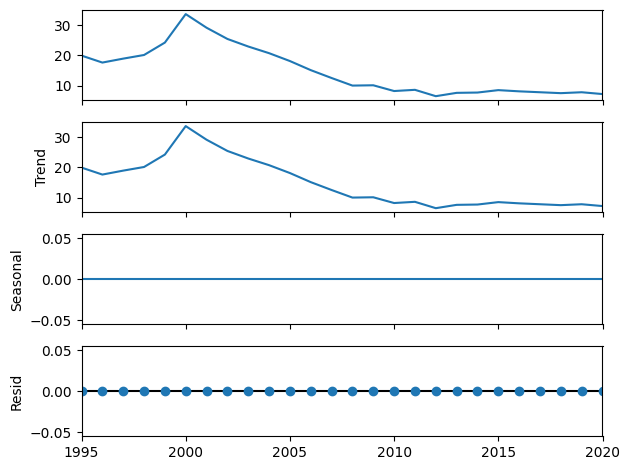

In [84]:
#импортируем библиотеку 
from statsmodels.tsa.seasonal import seasonal_decompose
#производим декомпозицию временного ряда 
decomposition = seasonal_decompose(poverty_percent_to_2021, period =1)
fig = decomposition.plot()
plt.show()

In [85]:
# Данные делим по порядку
train_df = poverty_percent_to_2021.iloc[:-1]
test_df = poverty_percent_to_2021.iloc[-1:]
train_df.shape, test_df.shape

((25, 1), (1, 1))

In [86]:
# Стационарность
from statsmodels.tsa.stattools import adfuller

def adfuller_test(df):
    test1 = adfuller(df)
    print("adf: ", test1[0])
    print("p-value: ", test1[1])
    print("Critical values: ", test1[4])
    if test1[0] > test1[4]["5%"]:
        print("Ряд нестационарен")
    else:
        print("Ряд стационарен")

adfuller_test(train_df)

adf:  -2.419827764101763
p-value:  0.13621819003466573
Critical values:  {'1%': -3.9644434814814815, '5%': -3.0849081481481484, '10%': -2.6818144444444445}
Ряд нестационарен


In [87]:
# Автоподбор параметров
import pmdarima as pm
smodel = pm.auto_arima(
    train_df,
    start_p=0,
    d=None,
    start_q=0,
    max_p=5,
    max_d=5,
    max_q=5,
    test="adf",
    error_action="ignore",
    trace=True
)
smodel_fit = smodel.fit(train_df)
# Предсказание AR
ar_pred = smodel_fit.predict(1)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=124.852, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=123.918, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=121.206, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=123.182, Time=0.19 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.915 seconds


In [88]:
# Предсказание экспонентой
from statsmodels.tsa.api import SimpleExpSmoothing
ses = SimpleExpSmoothing(train_df)
alpha = 0.7
model = ses.fit(smoothing_level = alpha, optimized = False)
exp_pred = model.forecast(1)
exp_pred

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency N will be used.



1970-01-01 00:00:00.000002020   7.75
Freq: N, dtype: float64

In [89]:
# Сравнение результатов
from sklearn.metrics import mean_absolute_percentage_error
print(mean_absolute_percentage_error(test_df, ar_pred)*100, mean_absolute_percentage_error(test_df, exp_pred)*100)

6.100747921625478 7.586464141194152


In [105]:
ar_pred.values

array([14.9])

### Проверю, насколько хорошо предсказываются значения для всех регионов

In [106]:
test_pred = {'region':[], 'y_test':[], 'pred':[], "MAPE":[]} # Сохранял получающиеся значения для оценки. Не необходимо, но интересно
for region in main.region.unique():

    test_pred['region'].append(region)
    poverty_percent_to_2021 = main[main['region']==region].iloc[:,1:3]
    poverty_percent_to_2021.set_index('year',inplace=True)

    train_df = poverty_percent_to_2021.iloc[:-1]
    test_df = poverty_percent_to_2021.iloc[-1:]
    test_pred['y_test'].append(test_df.values[0])
    
    smodel = pm.auto_arima(
        train_df,
        start_p=0,
        d=None,
        start_q=0,
        max_p=4,
        max_q=4,
        test="pp",
        error_action="ignore"
    )
    smodel_fit = smodel.fit(train_df)
    ar_pred = smodel_fit.predict(1)
    
    from statsmodels.tsa.api import SimpleExpSmoothing
    ses = SimpleExpSmoothing(train_df)
    model = ses.fit(smoothing_level = 0.7, optimized = False)
    exp_pred = model.forecast(1)

    pred = (min(ar_pred.values[0],np.array(exp_pred)[0]))
    test_pred['pred'].append(pred)
    
    test_pred['MAPE'].append(mean_absolute_percentage_error(test_df.values[0], [pred]).round(4)*100)

test_pred_df = pd.DataFrame(test_pred)
test_pred_df['MAPE'].mean()

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency N will be used.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency N will be used.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency N will be used.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency N will be used.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequen

3.094235294117647

Хороший результат. Сделаем предсказания для 2021 года и добавим в main 

### Предсказания poverty_percent на 2021

In [108]:
pred_dic = {'region':[], 'poverty_percent':[]}
for region in main.region.unique():
    
    pred_dic['region'].append(region)

    poverty_percent_to_2021 = main[main['region']==region].iloc[:,1:3]
    poverty_percent_to_2021.set_index('year',inplace=True)

    smodel = pm.auto_arima(
        poverty_percent_to_2021,
        start_p=0,
        d=None,
        start_q=0,
        max_p=4,
        max_q=4,
        test="pp",
        error_action="ignore"
    )
    smodel_fit = smodel.fit(poverty_percent_to_2021)
    ar_pred = smodel_fit.predict(1)
    
    from statsmodels.tsa.api import SimpleExpSmoothing
    ses = SimpleExpSmoothing(poverty_percent_to_2021)
    model = ses.fit(smoothing_level = 0.7, optimized = False)
    exp_pred = model.forecast(1)

    pred = (min(ar_pred.values[0],np.array(exp_pred)[0]))
    pred_dic['poverty_percent'].append(pred)

pred_df = pd.DataFrame(pred_dic)    

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency N will be used.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency N will be used.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency N will be used.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency N will be used.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequen

In [109]:
pred_df = pred_df.merge(pop_df[pop_df['year']==2021])

In [110]:
pred_df['poverty_population'] = pred_df['poverty_percent']/100 * pred_df['population']
pred_df.drop(['population','year'],axis =1)

,region,poverty_percent,poverty_population
0,Белгородская область,7.20,110970.65
1,Брянская область,13.40,158479.39
2,Владимирская область,12.40,166420.28
3,Воронежская область,8.50,195976.68
4,Ивановская область,13.20,130288.22
...,...,...,...
80,Амурская область,14.70,114931.36
81,Магаданская область,8.70,12095.96
82,Сахалинская область,7.30,35448.33
83,Еврейская автономная область,23.55,36863.33


## Кластеризация с предсказанными значениями бедностей

In [136]:
test = main[main.year==2020].drop(['poverty_population','poverty_percent'],axis = 1).merge(pred_df.drop(['population','year'],axis =1),on='region')
test = test.drop(['senior','disabled_percent','living_rooms','cramped_and_bad_conditions','counting_on_housing_from_gov'],axis=1)

In [137]:
cluster_df=test.reset_index(drop=True)
# Отложим метки регионов
save_region_data = cluster_df.loc[:,['region']].reset_index(drop=True)
cluster_df.drop(['region'],axis=1,inplace=True)

# подготовим данные к кластеризации
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
cluster_df_scaled = pd.DataFrame(ss.fit_transform(cluster_df),columns = cluster_df.columns)
from sklearn.decomposition import PCA
#определяем метод главных компонент с двумя компонентами
pca = PCA(n_components=0.9)
#обучаем алгоритм на наших данных
X_pca = pca.fit_transform(cluster_df_scaled)

In [147]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_pca)
cluster_res['pred_cluster'] = kmeans.labels_

In [148]:
px.scatter(cluster_res, x = 'poverty_population', y='poverty_percent', color='pred_cluster',
           hover_data={'region':True})

Курганская область ушла из кластера наибольшего процента бедности
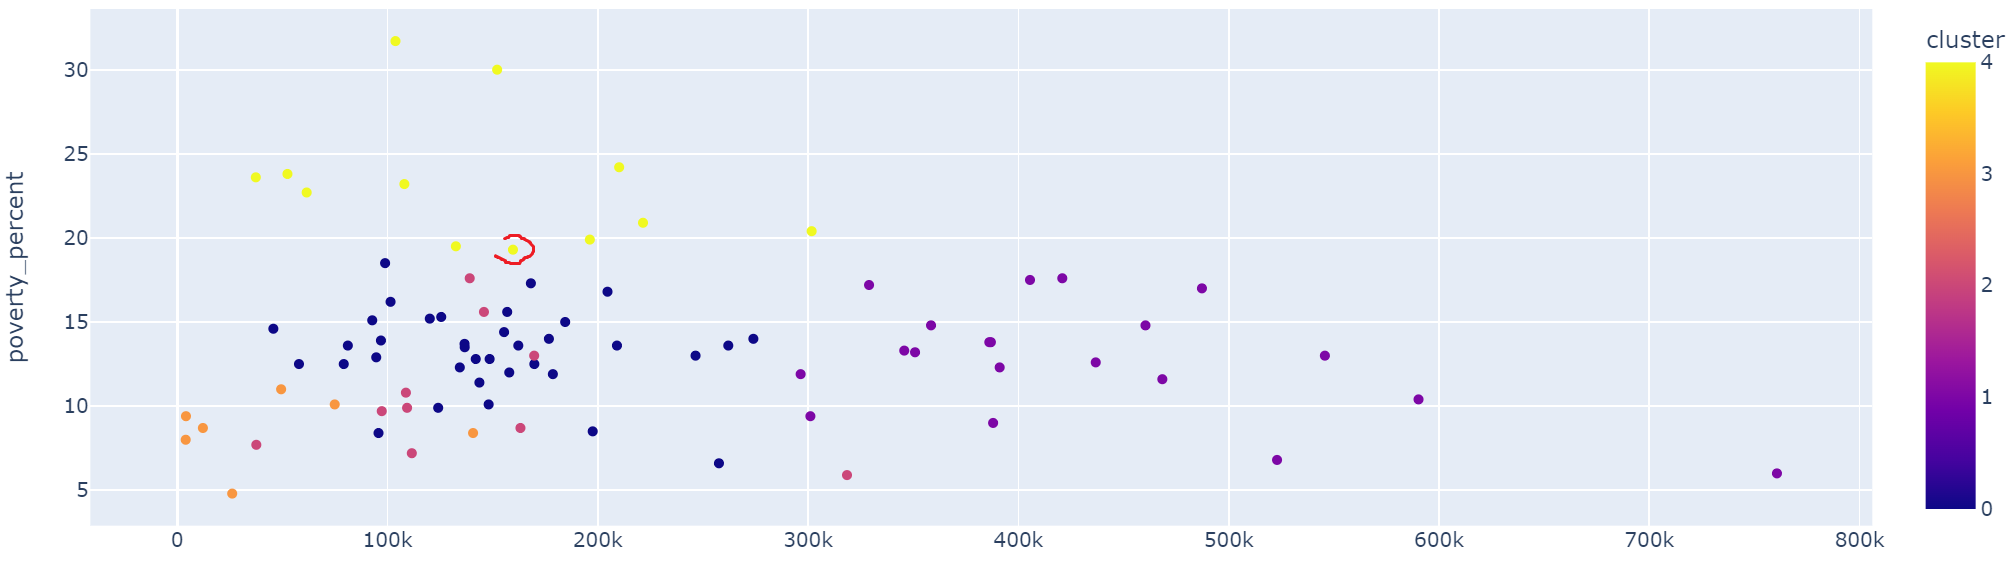
Минимальное, конечно, изменние, но всё же значимо

#  Экономика

## Валовой региональный продукт

In [ ]:
main = pd.read_pickle('main.pkl')

In [ ]:
grp_df = pd.read_excel('data/gross_regional_product_1996_2020.xls', skiprows=[0,1])
grp_df = grp_df.rename({grp_df.columns[0]: 'region'}, axis = 1)
grp_df = unified_regions(grp_df)
# конвертируем таблицу wide-to-long
grp_df = pd.melt(grp_df,id_vars='region',var_name='year',value_name='grp_value')
grp_df.year = grp_df.year.apply(int)
grp_df

In [ ]:
grp_df.info()

In [ ]:
grp_df.grp_value.value_counts(dropna=False)

В данных есть пропуски и нули. К сожалению, на слишком больших промежутках, чтобы как-то разумно их заменить. Заменим 0 на NA

In [ ]:
grp_df = grp_df.replace(0,np.nan).dropna(how='any', axis=0)

In [ ]:
set(main.region.unique())-(set(disabled.region.unique()))

In [ ]:
main = main.merge(grp_df, how='left', on=['region','year'])
px.imshow(main.corr(numeric_only=True),color_continuous_scale='Bluered') 

Прослеживается зависимость процента бедности от ВРП

In [ ]:
px.scatter(main, y ='poverty_percent', x='grp_value', log_y=True, hover_data=['region','year'])

Может даже логарифмическая зависимость? Что если убрать крайние значения?

In [ ]:
main.grp_value.quantile([0.1, 0.9])

In [ ]:
vis = main[main.grp_value.between(14004.32, 509867.48)]
px.imshow(vis.corr(numeric_only=True),color_continuous_scale='Bluered')

In [ ]:
fig = px.scatter(vis, y ='poverty_percent', x='grp_value', log_y=True, hover_data=['region','year'], trendline="ols", trendline_options=dict(log_x=True))
fig.show()
results = px.get_trendline_results(fig)
print(results)
results.px_fit_results.iloc[0].summary()

Есть явная зависимость бедности региона от значения ВРП

## Оборот розничной торговли на душу населения

In [ ]:
retail_turnover = pd.read_excel('data/retail_turnover_per_capita_2000_2021.xls', skiprows=[0,1,3])
retail_turnover

In [ ]:
retail_turnover = retail_turnover.drop(retail_turnover.columns[1], axis=1)
retail_turnover

In [ ]:
retail_turnover = retail_turnover.rename({retail_turnover.columns[0]: 'region'}, axis = 1)
retail_turnover = unified_regions(retail_turnover)
retail_turnover

In [ ]:
# конвертируем таблицу wide-to-long
retail_turnover_df = pd.melt(retail_turnover,id_vars='region',var_name='year',value_name='retail_turnover')
retail_turnover_df.year = retail_turnover_df.year.apply(int)
retail_turnover_df

In [ ]:
set(main.region.unique())-(set(retail_turnover_df.region.unique()))

In [ ]:
main = main.merge(retail_turnover_df, how='left', on=['region','year'])

In [ ]:
main.retail_turnover.value_counts(dropna=False)

При просмотре получившейся таблицы видно, что 0 это данные в областях-матрёшках. Можно вычислить эти значения, но довольно муторно. Думаю можно пропустить эти строчки. NaN для годов раньше 1999 тоже опустим, остальные заменим первым валидным значением

In [ ]:
vis = main[main['retail_turnover']!=0]
vis = vis[vis['year']>1999]
vis['retail_turnover'] = vis['retail_turnover'].bfill()
px.imshow(vis.corr(numeric_only=True),color_continuous_scale='Bluered') 

In [ ]:
px.scatter(vis, y ='poverty_percent', x='retail_turnover', hover_data=['region','year'])

Как же приятно работать с такими корреляциями! Попробуем аппроксимировать

In [ ]:
fig = px.scatter(vis, y ='poverty_percent', x='retail_turnover', log_y=True, hover_data=['region','year'], trendline="ols", trendline_options=dict(log_x=True))
fig.show()
results = px.get_trendline_results(fig)
results.px_fit_results.iloc[0].summary()


In [ ]:
fig = px.scatter(vis, y ='poverty_percent', x='retail_turnover', log_y=True, hover_data=['region','year'], trendline="ols", trendline_options=dict(log_x=True))
fig.show()
results = px.get_trendline_results(fig)
print(results)
results.px_fit_results.iloc[0].summary()

Видим, что оборот розничной торговли также коррелирует с процентом бедности в регионе. Хотя он и с ВРП достаточно скоррелирован (0.5)